In [1]:
# Cell 1: Imports and core data structures

import math
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple

import matplotlib.pyplot as plt

# Try to enable widgets if available
try:
    import ipywidgets as widgets
    from IPython.display import display
    HAVE_WIDGETS = True
except ImportError:
    HAVE_WIDGETS = False


@dataclass
class Task:
    name: str
    period_ms: float
    exec_ms: float
    deadline_ms: float = None
    # optional utility parameters for later (delay-sensitive vs tolerant)
    util_a: float = 0.0   # decay rate
    util_b: float = 0.0   # knee point [ms]

    def __post_init__(self):
        if self.deadline_ms is None:
            self.deadline_ms = self.period_ms

In [2]:
# Cell 2: Preemptive uniprocessor simulator for EDF / RM / FIFO

def build_jobs(tasks: List[Task],
               alpha_load: float,
               sim_time_ms: float) -> Tuple[List[Dict], float]:
    """
    Pre-generate all jobs for all tasks over [0, sim_time_ms).
    Scale execution time by alpha_load.
    Returns: [jobs], total utilization U.
    """
    jobs = []
    total_util = 0.0

    for task in tasks:
        C_scaled = task.exec_ms * alpha_load
        total_util += C_scaled / task.period_ms

        release = 0.0
        job_id = 0
        while release < sim_time_ms:
            deadline_abs = release + task.deadline_ms
            jobs.append({
                "task": task.name,
                "task_period": task.period_ms,
                "task_deadline_rel": task.deadline_ms,
                "release": release,
                "deadline": deadline_abs,
                "C": C_scaled,
                "remaining": C_scaled,
                "start": math.nan,
                "finish": math.nan,
                "missed": False,
                "response": math.nan,
                "tardiness": 0.0,
                "job_id": job_id,
            })
            job_id += 1
            release += task.period_ms

    # Sort by release time to make life easier
    jobs.sort(key=lambda j: j["release"])
    return jobs, total_util


def pick_job_index(ready_indices, jobs, scheduler_name):
    """
    Given indices of ready jobs, pick which job to execute next.
    """
    if not ready_indices:
        return None

    if scheduler_name == "EDF":
        # earliest absolute deadline first
        return min(ready_indices, key=lambda i: (jobs[i]["deadline"], jobs[i]["release"]))

    elif scheduler_name == "RM":
        # shortest period has highest priority
        return min(ready_indices, key=lambda i: (jobs[i]["task_period"], jobs[i]["release"]))

    elif scheduler_name == "FIFO":
        # first-come, first-served
        return min(ready_indices, key=lambda i: (jobs[i]["release"], jobs[i]["job_id"]))

    else:
        raise ValueError(f"Unknown scheduler: {scheduler_name}")


def simulate_generic(tasks: List[Task],
                     scheduler_name: str,
                     sim_time_ms: float,
                     alpha_load: float,
                     dt_ms: float = 1.0) -> Tuple[List[Dict], Dict]:
    """
    Run a time-driven simulation for one scheduler and one α.
    Returns:
      - jobs_out: list of job dicts with filled metrics
      - effort: dict with effort metrics (per-scheduler, per-α)
    """
    jobs, total_util = build_jobs(tasks, alpha_load, sim_time_ms)

    t = 0.0
    n_steps = int(sim_time_ms / dt_ms)

    ready_indices = []
    next_release_index = 0

    # scheduler effort metrics (approximate)
    ready_len_sum = 0
    ready_len_max = 0

    for _step in range(n_steps):
        # 1) add newly released jobs
        while (next_release_index < len(jobs) and
               jobs[next_release_index]["release"] <= t + 1e-9):
            ready_indices.append(next_release_index)
            next_release_index += 1

        # 2) prune finished jobs from ready list
        ready_indices = [i for i in ready_indices if jobs[i]["remaining"] > 0]

        ready_len = len(ready_indices)
        ready_len_sum += ready_len
        ready_len_max = max(ready_len_max, ready_len)

        # 3) pick job to run
        idx = pick_job_index(ready_indices, jobs, scheduler_name)

        if idx is not None:
            job = jobs[idx]
            # mark start
            if math.isnan(job["start"]):
                job["start"] = t

            # execute dt
            job["remaining"] -= dt_ms

            # if finished in this step
            if job["remaining"] <= 0 and math.isnan(job["finish"]):
                job["finish"] = t + dt_ms
                job["response"] = job["finish"] - job["release"]
                lateness = job["finish"] - job["deadline"]
                job["tardiness"] = max(0.0, lateness)
                job["missed"] = job["finish"] > job["deadline"]

        # advance time
        t += dt_ms

    # handle jobs that never finished (very overloaded)
    for job in jobs:
        if math.isnan(job["finish"]):
            job["finish"] = sim_time_ms
            job["response"] = sim_time_ms - job["release"]
            lateness = job["finish"] - job["deadline"]
            job["tardiness"] = max(0.0, lateness)
            job["missed"] = True

    # add scheduler + α + util to each job
    for job in jobs:
        job["scheduler"] = scheduler_name
        job["alpha"] = alpha_load
        job["util"] = total_util

    # effort
    effort = {
        "scheduler": scheduler_name,
        "alpha": alpha_load,
        "util": total_util,
        "avg_ready_len": ready_len_sum / max(n_steps, 1),
        "max_ready_len": ready_len_max,
        "steps": n_steps,
    }
    return jobs, effort

In [3]:
# Cell 3: Summaries and plotting

def summarize_jobs_with_metrics(jobs_all: List[Dict]):
    df_jobs = pd.DataFrame(jobs_all)

    # Per-scheduler aggregate (ignoring tasks) – for latency & miss ratio vs α
    df_sched = (
        df_jobs
        .groupby(["scheduler", "alpha"], as_index=False)
        .agg(
            avg_latency_ms=("response", "mean"),
            std_latency_ms=("response", "std"),
            miss_ratio=("missed", "mean"),
            avg_tardiness_ms=("tardiness", "mean"),
            jobs=("job_id", "count"),
            util=("util", "mean"),
        )
    )

    # Per-task summary (could be used later if you want per-sensor curves)
    df_task = (
        df_jobs
        .groupby(["scheduler", "alpha", "task"], as_index=False)
        .agg(
            avg_latency_ms=("response", "mean"),
            miss_ratio=("missed", "mean"),
            avg_tardiness_ms=("tardiness", "mean"),
            jobs=("job_id", "count"),
        )
    )

    return df_jobs, df_sched, df_task


def plot_dashboard(df_sched, df_jobs, df_effort, example_scheduler="EDF",
                   example_task=None, title_prefix="Generic task set"):
    """
    Professional-looking 2×2 dashboard:
      (1) avg latency vs α
      (2) miss ratio vs α
      (3) effort vs utilization
      (4) tardiness over time for one scheduler & task
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    ax_lat, ax_miss, ax_eff, ax_tard = axs.ravel()

    # global styling
    for ax in axs.ravel():
        ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)
        ax.set_facecolor("white")

    # 1) Average latency vs load
    for sched in sorted(df_sched["scheduler"].unique()):
        sub = df_sched[df_sched["scheduler"] == sched].sort_values("alpha")
        ax_lat.plot(sub["alpha"], sub["avg_latency_ms"], marker="o", label=sched)
    ax_lat.set_xlabel("Load factor α")
    ax_lat.set_ylabel("Average response time [ms]")
    ax_lat.set_title("Average latency vs load")
    ax_lat.legend(title="Scheduler")

    # 2) Miss ratio vs load
    for sched in sorted(df_sched["scheduler"].unique()):
        sub = df_sched[df_sched["scheduler"] == sched].sort_values("alpha")
        ax_miss.plot(sub["alpha"], sub["miss_ratio"], marker="s", label=sched)
    ax_miss.set_xlabel("Load factor α")
    ax_miss.set_ylabel("Deadline miss ratio")
    ax_miss.set_title("Deadline miss ratio vs load")
    ax_miss.set_ylim(0, 1.05)
    ax_miss.legend(title="Scheduler")

    # 3) Effort vs utilization
    for sched in sorted(df_effort["scheduler"].unique()):
        sub = df_effort[df_effort["scheduler"] == sched].sort_values("util")
        ax_eff.plot(sub["util"] * 100.0, sub["max_ready_len"], marker="^", label=sched)
    ax_eff.set_xlabel("Total utilization U [%]")
    ax_eff.set_ylabel("Max ready-queue length (effort proxy)")
    ax_eff.set_title("Scheduler effort vs utilization")
    ax_eff.legend(title="Scheduler")

    # 4) Tardiness over time for one scheduler & task
    if example_task is None:
        example_task = df_jobs["task"].unique()[0]

    sub = (
        df_jobs[
            (df_jobs["scheduler"] == example_scheduler)
            & (df_jobs["task"] == example_task)
        ]
        .sort_values("release")
    )
    ax_tard.plot(sub["release"], sub["tardiness"],
                 color="darkred", linewidth=1.8)
    ax_tard.set_xlabel("Release time [ms]")
    ax_tard.set_ylabel("Tardiness [ms]")
    ax_tard.set_title(f"Tardiness over time – {example_task} ({example_scheduler})")

    fig.suptitle(title_prefix, fontsize=16, fontweight="bold")
    fig.tight_layout()
    plt.show()

In [8]:
# ============================================================
# GENERIC HETEROGENEOUS EXPERIMENT: EDF vs RM vs FIFO
# Many "sensors", different periods & deadlines
# ============================================================

import pandas as pd

# ---- 1) Define a realistic heterogeneous task set ----
# We create 3 traffic classes: critical, control, monitoring.
# Counts chosen so that total utilization at alpha=1 ≈ 0.92 (< 1),
# so alpha > 1 pushes the system into overload.

tasks_generic = []

# Critical: very fast, tight deadline (like emergency sensors)
# T = 50 ms,  C = 5 ms,  D = 50 ms
for i in range(4):
    tasks_generic.append(Task(
        name=f"Crit{i+1}",
        period_ms=50,
        exec_ms=5,
        deadline_ms=50
    ))

# Control: medium period, deadline slightly *shorter* than period
# T = 100 ms, C = 8 ms, D = 80 ms
for i in range(4):
    tasks_generic.append(Task(
        name=f"Ctrl{i+1}",
        period_ms=100,
        exec_ms=8,
        deadline_ms=80
    ))

# Monitoring: slow, soft deadline
# T = 200 ms, C = 10 ms, D = 150 ms
for i in range(4):
    tasks_generic.append(Task(
        name=f"Mon{i+1}",
        period_ms=200,
        exec_ms=10,
        deadline_ms=150
    ))

# Quick sanity check: base utilization at alpha = 1
U_base = sum(t.exec_ms / t.period_ms for t in tasks_generic)
print(f"Base total utilization U (alpha=1): {U_base:.3f}  (~{U_base*100:.1f}%)")

# ---- 2) Simulation parameters ----
sim_time_ms = 60_000   # 60 s “virtual time”
alpha_list  = [0.5, 0.75, 1.0, 1.25, 1.5]  # from light load to overloaded

print("α values:", alpha_list)
print("Tasks:")
for t in tasks_generic:
    print(f"  {t.name}: T={t.period_ms} ms, C={t.exec_ms} ms, D={t.deadline_ms} ms")

# ---- 3) Run EDF / RM / FIFO for each alpha ----

all_jobs = []
effort_rows = []

for alpha in alpha_list:
    for sched in ["EDF", "RM", "FIFO"]:
        jobs, effort = simulate_generic(
            tasks_generic,
            scheduler_name=sched,
            sim_time_ms=sim_time_ms,
            alpha_load=alpha,   # scales C
            dt_ms=1.0,
            util_scale_ms=50.0,
        )
        all_jobs.extend(jobs)
        effort_rows.append(effort)

# ---- 4) Build dataframes ----
df_jobs_generic, df_summary_generic = summarize_jobs_with_metrics(all_jobs)
df_effort_generic = pd.DataFrame(effort_rows)

# Save for later analysis in CSV
df_jobs_generic.to_csv("generic_jobs.csv", index=False)
df_summary_generic.to_csv("generic_summary_sched.csv", index=False)
df_effort_generic.to_csv("generic_effort.csv", index=False)

print(f"\nTotal jobs: {len(df_jobs_generic)}")
print("Wrote CSV files: generic_jobs.csv, generic_summary_sched.csv, generic_effort.csv")

# ---- 5) Plot full dashboard for the generic experiment ----
# Use one critical task as the “example” for the tardiness sub-plot
example_task_generic = "Crit1"

plot_dashboard(
    df_summary_generic,
    df_jobs_generic,
    df_effort_generic,
    example_task_generic,
    title_prefix="Generic heterogeneous task set: EDF vs RM vs FIFO"
)

Base total utilization U (alpha=1): 0.920  (~92.0%)
α values: [0.5, 0.75, 1.0, 1.25, 1.5]
Tasks:
  Crit1: T=50 ms, C=5 ms, D=50 ms
  Crit2: T=50 ms, C=5 ms, D=50 ms
  Crit3: T=50 ms, C=5 ms, D=50 ms
  Crit4: T=50 ms, C=5 ms, D=50 ms
  Ctrl1: T=100 ms, C=8 ms, D=80 ms
  Ctrl2: T=100 ms, C=8 ms, D=80 ms
  Ctrl3: T=100 ms, C=8 ms, D=80 ms
  Ctrl4: T=100 ms, C=8 ms, D=80 ms
  Mon1: T=200 ms, C=10 ms, D=150 ms
  Mon2: T=200 ms, C=10 ms, D=150 ms
  Mon3: T=200 ms, C=10 ms, D=150 ms
  Mon4: T=200 ms, C=10 ms, D=150 ms


TypeError: simulate_generic() got an unexpected keyword argument 'util_scale_ms'

Project simulation complete. Wrote CSV files: project_jobs, project_summary_sched, project_summary_task, project_effort.


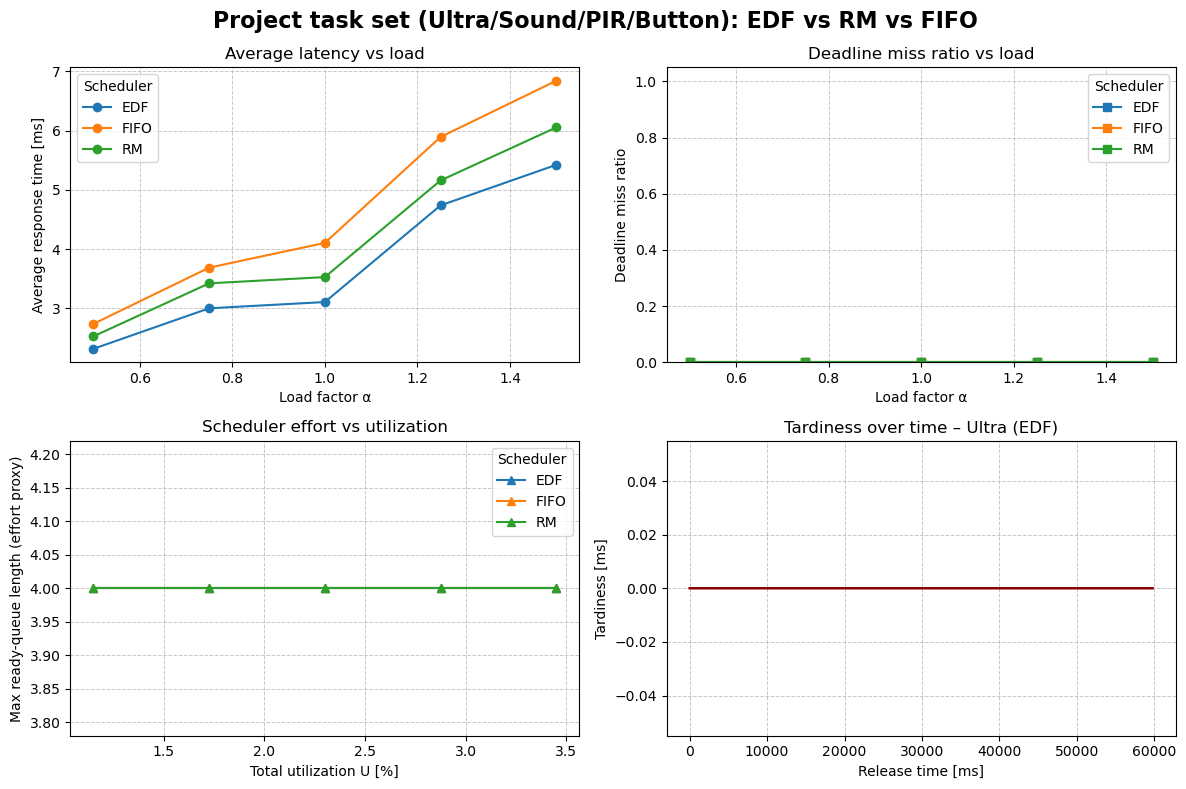

In [5]:
# Cell 5: Project-specific 4-task simulation (your ESP32 setup)

tasks_project = [
    Task("Ultra",  period_ms=200.0,  exec_ms=3.0,  deadline_ms=200.0),
    Task("Sound",  period_ms=2000.0, exec_ms=8.0,  deadline_ms=2000.0),
    Task("PIR",    period_ms=500.0,  exec_ms=1.0,  deadline_ms=100.0),
    Task("Button", period_ms=500.0,  exec_ms=1.0,  deadline_ms=150.0),
]

sim_time_ms_proj = 60_000.0
alpha_list_proj = [0.5, 0.75, 1.0, 1.25, 1.5]

all_jobs_proj = []
effort_rows_proj = []

for alpha in alpha_list_proj:
    for sched in ["EDF", "RM", "FIFO"]:
        jobs, effort = simulate_generic(
            tasks_project,
            scheduler_name=sched,
            sim_time_ms=sim_time_ms_proj,
            alpha_load=alpha,
            dt_ms=1.0,
        )
        all_jobs_proj.extend(jobs)
        effort_rows_proj.append(effort)

df_jobs_proj, df_sched_proj, df_task_proj = summarize_jobs_with_metrics(all_jobs_proj)
df_effort_proj = pd.DataFrame(effort_rows_proj)

df_jobs_proj.to_csv("project_jobs.csv", index=False)
df_sched_proj.to_csv("project_summary_sched.csv", index=False)
df_task_proj.to_csv("project_summary_task.csv", index=False)
df_effort_proj.to_csv("project_effort.csv", index=False)

print("Project simulation complete. Wrote CSV files: project_jobs, project_summary_sched, "
      "project_summary_task, project_effort.")

# Use Ultra as example in the tardiness subplot
plot_dashboard(
    df_sched_proj,
    df_jobs_proj,
    df_effort_proj,
    example_scheduler="EDF",
    example_task="Ultra",
    title_prefix="Project task set (Ultra/Sound/PIR/Button): EDF vs RM vs FIFO",
)

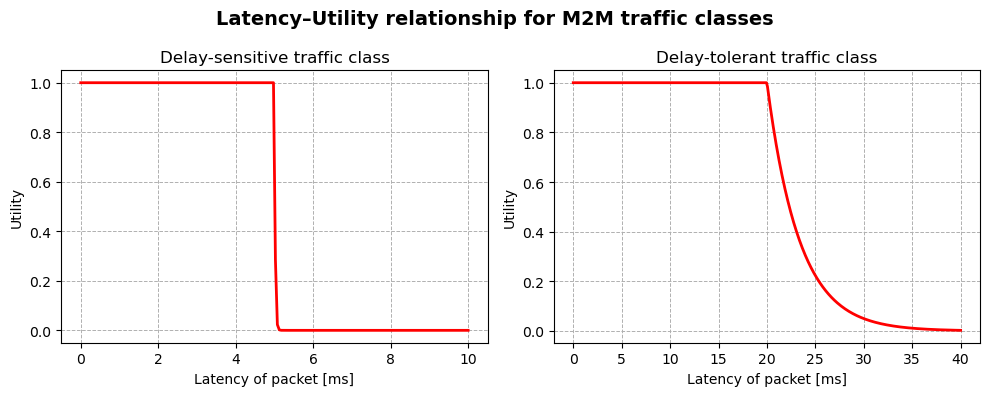

In [6]:
# Cell 6: Utility vs latency curves (delay-sensitive vs delay-tolerant)

def utility_curve(latency_ms, a, b):
    """Simple exponential utility: 1 up to b, then decays with rate a."""
    u = np.ones_like(latency_ms)
    mask = latency_ms > b
    u[mask] = np.exp(-a * (latency_ms[mask] - b))
    return u

L1 = np.linspace(0, 10, 200)
L2 = np.linspace(0, 40, 400)

u_delay_sensitive = utility_curve(L1, a=50.0, b=5.0)
u_delay_tolerant  = utility_curve(L2, a=0.3,  b=20.0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(L1, u_delay_sensitive, 'r', linewidth=2)
ax1.set_xlabel("Latency of packet [ms]")
ax1.set_ylabel("Utility")
ax1.set_title("Delay-sensitive traffic class")
ax1.grid(True, linestyle="--", linewidth=0.7)

ax2.plot(L2, u_delay_tolerant, 'r', linewidth=2)
ax2.set_xlabel("Latency of packet [ms]")
ax2.set_ylabel("Utility")
ax2.set_title("Delay-tolerant traffic class")
ax2.grid(True, linestyle="--", linewidth=0.7)

fig.suptitle("Latency–Utility relationship for M2M traffic classes", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()